In [43]:
train_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\train"
val_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\val"
test_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\test"

In [44]:
import pandas as pd
import os

def count_images_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')])
    return count
    
train_images = count_images_in_directory(train_dir)
val_images = count_images_in_directory(val_dir)
test_images = count_images_in_directory(test_dir)

print(f"Training images: {train_images}")
print(f"Validation images: {val_images}")
print(f"Test images: {test_images}")

Training images: 9246
Validation images: 829
Test images: 506


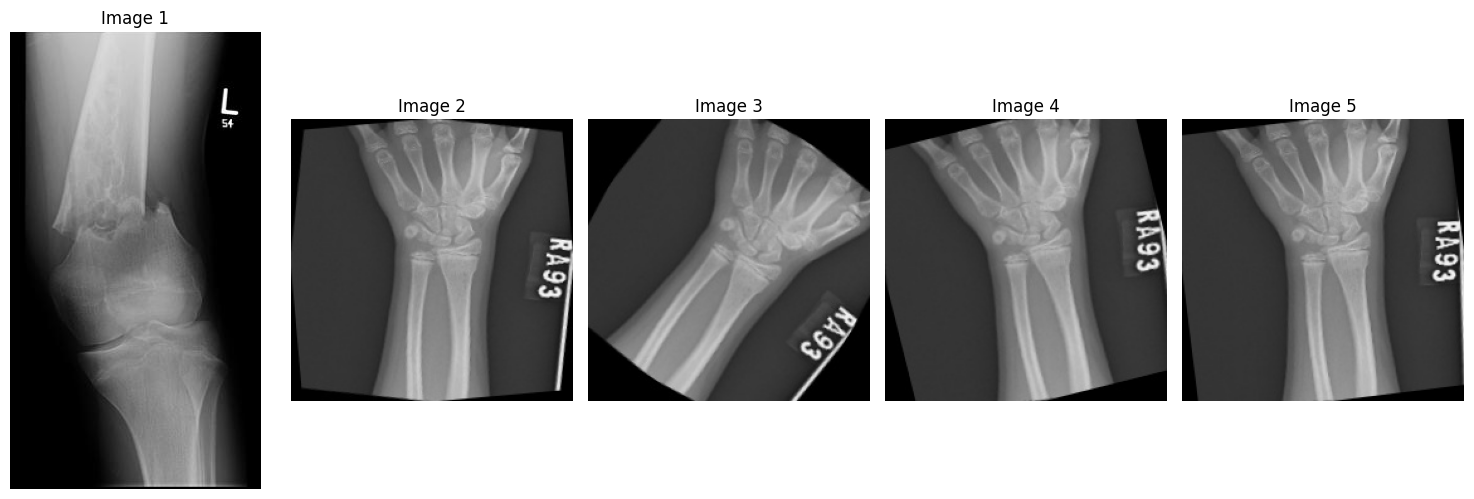

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt

folder_path = 'D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/val/fractured'

image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
image_files = image_files[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, image_file in enumerate(image_files):
    img_path = os.path.join(folder_path, image_file)  # Full path to the image
    img = Image.open(img_path)                       
    axes[i].imshow(img)                              
    axes[i].axis('off')                              
    axes[i].set_title(f"Image {i+1}")                

plt.tight_layout()
plt.show()


- `root` - current directory.
- `dirs` - list of directories in the current directory.

In [3]:
def identify_and_remove_corrupted_images(dataset_dir):
    corrupted_images = [] 

    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            try:
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    img.load()
            except (IOError, OSError) as e:
                print(f"Corrupted image detected: {image_path}")
                corrupted_images.append(image_path)

    return corrupted_images

train_dataset_dir = 'D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/val/'
val_dataset_dir = 'D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/val/'
corrupted_images_train = identify_and_remove_corrupted_images('D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/train/')
corrupted_images_val = identify_and_remove_corrupted_images('D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/val/')

print(f"Number of corrupted images found in train dataset: {len(corrupted_images_train)}")
print(f"Number of corrupted images found in validation dataset: {len(corrupted_images_val)}")

Corrupted image detected: D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/train/not fractured\IMG0004134.jpg
Corrupted image detected: D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/train/not fractured\IMG0004143.jpg
Corrupted image detected: D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/train/not fractured\IMG0004148.jpg
Corrupted image detected: D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/train/not fractured\IMG0004149.jpg
Corrupted image detected: D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/train/not fractured\IMG0004308.jpg
Corrupted image detected: D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/train/not fractured\IMG0004347.jpg
Corrupted image detected: D:/College Notes/5th Sem/CS307 Machine Learning 4/Bone_Fracture_Binary_Classification/val/no

In [ ]:
!pip install pillow #opening n loading images

In [5]:
import torchvision.transforms as transforms  # For data transformations
# Dictionary containing transformation pipelines for training and validation data
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),                           # Convert image to tensor
        transforms.CenterCrop(400),                      # Crop the center of the image to size 400x400
        transforms.RandomHorizontalFlip(),               # Randomly flip the image horizontally with a probability of 50%
        transforms.Grayscale(num_output_channels=1)]),   # Convert the image to grayscale with a single channel

    'val': transforms.Compose([
        transforms.ToTensor(),                           # Convert image to tensor
        transforms.CenterCrop(400),                      # Crop the center of the image to size 400x400
        transforms.Grayscale(num_output_channels=1)])   # Convert the image to grayscale with a single channel for validation
}

In [7]:
# Data points (training examples)
BATCH_SIZE = 32  

In [8]:
from torchvision.datasets import ImageFolder  # For loading image datasets
# Update the datasets to remove corrupted images
train_dataset = ImageFolder(root=train_dataset_dir,
                            transform=data_transforms['train'],
                            target_transform=None,
                            is_valid_file=None)
val_dataset = ImageFolder(root=val_dataset_dir,
                          transform=data_transforms['val'],
                          target_transform=None,
                          is_valid_file=None)

# Excluding the corrupted images from the dataset
train_dataset.samples = [(img, target) for img, target in train_dataset.samples if img not in corrupted_images_train]
val_dataset.samples = [(img, target) for img, target in val_dataset.samples if img not in corrupted_images_val]

from torch.utils.data import DataLoader  # For batch data loading
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [41]:
# Defining the directory path to the original dataset
original_dataset_dir = r"D:\College Notes\5th Sem\CS307 Machine Learning 4\Bone_Fracture_Binary_Classification\train"

# Listing the classes (subdirectories) in the original dataset directory
classes = os.listdir(original_dataset_dir)

# Printing the number of classes and the list of classes
print(len(classes))  
print(classes)

2
['fractured', 'not fractured']


#### Visual understanding of the dataset during the development of ML model

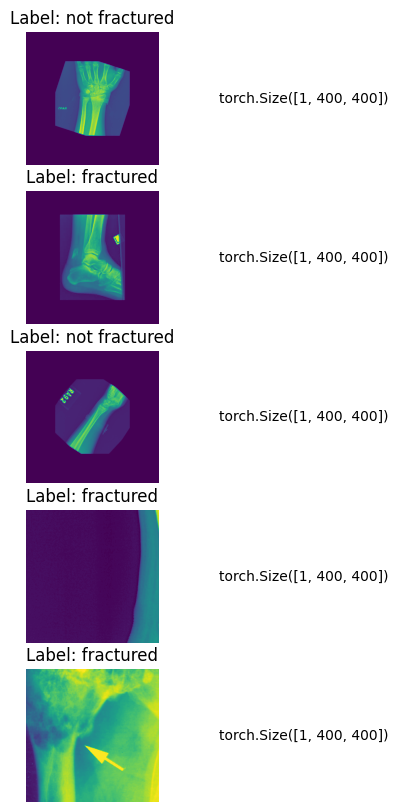

In [33]:
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical operations

# Function to display images with their sizes
def show_images_with_sizes(dataloader, classes, num_images=5):
    # Get a batch of data
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Define the figure
    fig, axs = plt.subplots(num_images, 2, figsize=(5, 10))

    # Display images and sizes
    for idx in range(num_images):
        img = images[idx].permute(1, 2, 0)  # Permute dimensions to (H, W, C) for display
        axs[idx, 0].imshow(img)
        axs[idx, 0].set_title(f"Label: {classes[labels[idx]]}")  # Display the label
        axs[idx, 0].axis('off')  # Turn off axis

        # Display tensor size
        axs[idx, 1].text(0.5, 0.5, str(images[idx].size()), horizontalalignment='center', verticalalignment='center')
        axs[idx, 1].axis('off')  # Turn off axis

    plt.show()  # Show the plot

# Call the function to display images with their sizes
show_images_with_sizes(train_loader, classes, num_images=5)

#### Building ML Model

In [9]:
!pip install torch torchvision

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.8/199.4 MB 2.8 MB/s eta 0:01:11
   ---------------------------------------- 1.6/199.4 MB 3.0 MB/s eta 0:01:06
    --------------------------------------- 2.6/199.4 MB 3.6 MB/s eta 0:00:55
    --------------------------------------- 3.7/199.4 MB 4.0 MB/s eta 0:00:50
    --------------------------------------- 4.5/199.4 MB 3.9 MB/s eta 0:00:51
   - -------------------------------------- 5.2/199.4 MB 3.9 MB/s eta 0:00:50
   - -------------------------------------- 7.1/199.4 MB 4.5 MB/s eta 0:00:43
   - -------------------------------------- 8.7/199.4 MB

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [13]:
# Load the pre-trained ResNet model (e.g., ResNet50)
model = models.resnet50(weights='IMAGENET1K_V1')  # Using the pre-trained weights

# Modify the final layer to match your number of classes (2 for binary classification)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Change output layer for binary classification

# Move the model to the appropriate device
model = model.to(device)

# Print the model summary
print(model)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\daans/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

In [15]:
# Function to train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            
            running_loss += loss.item()  # Accumulate loss

        # Print training loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Validate the model
        validate_model(model, val_loader)

# Function to validate the model
def validate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predictions
            total += labels.size(0)  # Count total samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')